In [3]:
import sys
sys.path.append("..")

from lib.models.llava.llava_captioner import LLaVACaptioner

import PIL

In [2]:
!pip install accelerate==0.21.0
!pip install einops==0.6.1
!pip install timm==0.6.13
!pip install tokenizers==0.15.1
!pip install transformers==4.37.2

In [4]:
llava_captioner = LLaVACaptioner()

/home/altair/miniconda3/envs/lenv/lib/python3.12/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
You are using a model of type llava to instantiate a model of type llava_llama. This is not supported for all configurations of models and can yield errors.
/home/altair/miniconda3/envs/lenv/lib/python3.12/site-packages/torch/nn/modules/module.py:2025: UserWarning: for vision_model.embeddings.class_embedding: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(f'for {key}: copying from a non-meta parameter in the checkpoint to a meta '
/home/altair/miniconda3/en

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [5]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

In [11]:
# Загрузка данных траектории
trajectory = np.load('/mnt/vol0/datasets/rosbag2_navigation_for_graph_21_feb_2024/trajectory.npy')

In [12]:
# Проверка формы и типа данных
print("Форма данных траектории:", trajectory.shape)
print("Тип данных траектории:", trajectory.dtype)

Форма данных траектории: (1923, 3)
Тип данных траектории: float64


## animation

In [25]:
# Функция для инициализации графика
def init():
    line.set_data([], [])
    return line,

# Функция для анимации
def animate(i):
    x = trajectory[:i+1, 0]
    y = trajectory[:i+1, 1]
    line.set_data(x, y)

    # Обновляем позицию стрелки для ориентации
    if i > 0:
        dx = np.cos(trajectory[i, 2])  # Используем угол yaw для расчёта направления стрелки по оси X
        dy = np.sin(trajectory[i, 2])  # Используем угол yaw для расчёта направления стрелки по оси Y
        arrow.xy = (x[-1], y[-1])  # Начальная точка стрелки
        arrow.set_position((x[-1] + dx, y[-1] + dy))  # Конечная точка стрелки

    return line, arrow


In [26]:
# Создание фигуры и осей
fig, ax = plt.subplots()
ax.set_xlim(np.min(trajectory[:, 0]), np.max(trajectory[:, 0]))
ax.set_ylim(np.min(trajectory[:, 1]), np.max(trajectory[:, 1]))
line, = ax.plot([], [], lw=2)
arrow = ax.annotate("", xy=(0,0), xytext=(20,20), textcoords="offset points",
                    arrowprops=dict(arrowstyle="->", lw=1.5))

In [ ]:
# Создание анимации
ani = animation.FuncAnimation(fig, animate, init_func=init, frames=len(trajectory), interval=100, blit=True)

# Сохранение анимации в файл
ani.save('/home/altair/gan/final/multinav/notebooks/trajectory_animation1.mp4', writer='ffmpeg', fps=100)

# Показываем результат в блокноте
plt.close(fig)  # Закрываем фигуру после сохранения, чтобы не отображать ее здесь
'/home/altair/gan/final/multinav/notebooks/trajectory_animation1.mp4'  # Путь к файлу анимации, который вы можете загрузить

## Frames selection

In [13]:
trajectory

array([[ 0.00000000e+00,  1.20000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  1.20000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  1.20000000e+00,  0.00000000e+00],
       ...,
       [-4.01965451e-02,  2.96057322e-01,  1.36078457e-04],
       [-4.01965451e-02,  2.96057322e-01,  1.36078457e-04],
       [-4.01965451e-02,  2.96057322e-01,  1.36078457e-04]])

In [14]:
x = trajectory[:,0]
y = trajectory[:,1]

In [15]:
plt.figure(figsize=(10, 5))
plt.plot(x, y, marker='o', linestyle='-')  # Используем круглые маркеры для каждой точки
plt.title('Trajectory')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(True)
plt.show()

In [16]:
def find_indices_exceeding_distance(points, threshold):
    indices = [0]  # Начинаем список индексов с первого индекса
    last_index = 0  # Последний сохраненный индекс

    for i in range(1, len(points)):
        # Вычисляем Евклидово расстояние между последней сохраненной точкой и текущей
        distance = np.linalg.norm(points[last_index] - points[i])
        # Если расстояние превышает порог, сохраняем текущий индекс и обновляем последний сохраненный индекс
        if distance > threshold:
            indices.append(i)
            last_index = i

    return indices

In [17]:
points = np.column_stack((x, y))

In [18]:
points

array([[ 0.        ,  1.2       ],
       [ 0.        ,  1.2       ],
       [ 0.        ,  1.2       ],
       ...,
       [-0.04019655,  0.29605732],
       [-0.04019655,  0.29605732],
       [-0.04019655,  0.29605732]])

In [75]:
# distance between key frame and next frame
threshold = 7 #2.3

# Getting indexes which are bigger than our threshold
indices = find_indices_exceeding_distance(points, threshold)

In [76]:
#indices

In [77]:
len(indices)

65

In [78]:
# to path format, to check image
image_paths = [
    f"/mnt/vol0/datasets/rosbag2_navigation_for_graph_21_feb_2024/rgb_images/{str(index).zfill(5)}.jpg" for index in indices
]

In [89]:
# Путь к файлу изображения
image_path = image_paths[25]

# Загрузка изображения
image = PIL.Image.open(image_path)
image.show()


In [90]:
len(image_paths)

65

In [91]:
from tqdm import tqdm
import pandas as pd
import os
import torch

In [92]:
def batchify(lst, batch_size):
    for i in range(0, len(lst), batch_size):
        yield lst[i:i + batch_size]

In [93]:
# batch size
batch_size = 4

In [94]:
results = []

# Путь для сохранения CSV-файла
save_path = '/home/altair/gan/final/multinav/notebooks'
os.makedirs(save_path, exist_ok=True)  # Создает директорию, если она не существует
csv_file = os.path.join(save_path, 'llava_outputs.csv')

In [95]:
# Обрабатываем изображения батчами с прогресс-баром
for batch_image_paths in tqdm(batchify(image_paths, batch_size), total=(len(image_paths) + batch_size - 1) // batch_size, desc="Processing images"):
    # Загружаем изображения для текущего батча
    batch_images = [PIL.Image.open(img_path).convert("RGB") for img_path in batch_image_paths]
    
    # Генерируем описания для текущего батча
    outputs = llava_captioner(batch_images, mode="scene")
    
    # Собираем результаты с путями к изображениям
    for img_path, output in zip(batch_image_paths, outputs):
        results.append({'image_path': img_path, 'output': output})
    
    # Освобождаем память GPU
    torch.cuda.empty_cache()
    
    # Сохраняем промежуточные результаты каждые N батчей (опционально)
    if len(results) % (batch_size * 10) == 0:
        df = pd.DataFrame(results)
        df.to_csv(csv_file, index=False)
        print(f"Saved {len(results)} entries to {csv_file}")

Processing images:  59%|█████████████████████████████████████▋                          | 10/17 [03:33<02:42, 23.26s/it]

Saved 40 entries to /home/altair/gan/final/multinav/notebooks/llava_outputs.csv


Processing images: 100%|████████████████████████████████████████████████████████████████| 17/17 [05:48<00:00, 20.50s/it]


In [96]:
# Сохраняем окончательные результаты
df = pd.DataFrame(results)
df.to_csv(csv_file, index=False)
print(f"Processing completed. Results saved to {csv_file}")

Processing completed. Results saved to /home/altair/gan/final/multinav/notebooks/llava_outputs.csv


In [106]:
#example of caption
df.loc[10][1]

/tmp/ipykernel_1264265/2625323205.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df.loc[10][1]


'The image shows an interior space that appears to be a corridor or hallway. The floor is carpeted in a dark color, and the walls are a light gray, possibly concrete. There are several columns visible, which are likely part of the structural design of the building.\n\nOn the left side of the image, there is a railing that seems to be a safety barrier, possibly indicating a walkway or a balcony area. The railing is made of a metal material and is mounted on the wall.\n\nIn the center of the image, there is a wooden counter or barrier that serves as a partition or barrier between the walkway and the rest of the space. The counter is supported by vertical posts and has a flat top surface.\n\nOn the right side of the image, there is a doorway that leads to another room or area. The door is closed, and there is a sign above it, although the text on the sign is not legible in the image.\n\nThe lighting in the space is artificial, with recessed lighting fixtures in the ceiling. The overall at

In [103]:
df

image_path  \
0   /mnt/vol0/datasets/rosbag2_navigation_for_grap...   
1   /mnt/vol0/datasets/rosbag2_navigation_for_grap...   
2   /mnt/vol0/datasets/rosbag2_navigation_for_grap...   
3   /mnt/vol0/datasets/rosbag2_navigation_for_grap...   
4   /mnt/vol0/datasets/rosbag2_navigation_for_grap...   
..                                                ...   
60  /mnt/vol0/datasets/rosbag2_navigation_for_grap...   
61  /mnt/vol0/datasets/rosbag2_navigation_for_grap...   
62  /mnt/vol0/datasets/rosbag2_navigation_for_grap...   
63  /mnt/vol0/datasets/rosbag2_navigation_for_grap...   
64  /mnt/vol0/datasets/rosbag2_navigation_for_grap...   

                                               output  
0   In the image, I see a whiteboard mounted on a ...  
1   The image shows an interior space that appears...  
2   The image shows an interior space that appears...  
3   The image shows a view through an open doorway...  
4   The image shows an interior hallway of a build...  
..                                                ...  
60  The image depicts an interior space that appea...  
61  The image shows an interior view of a modern o...  
62  The image shows an interior view of a modern o...  
63  The image shows an interior hallway with a mod...  
64  The image shows an interior space that appears...  

[65 rows x 2 columns]

# Batch API JSONL file creation

In [6]:
import pandas as pd

df = pd.read_csv('llava_outputs.csv')

In [7]:
df

image_path  \
0   /mnt/vol0/datasets/rosbag2_navigation_for_grap...   
1   /mnt/vol0/datasets/rosbag2_navigation_for_grap...   
2   /mnt/vol0/datasets/rosbag2_navigation_for_grap...   
3   /mnt/vol0/datasets/rosbag2_navigation_for_grap...   
4   /mnt/vol0/datasets/rosbag2_navigation_for_grap...   
..                                                ...   
60  /mnt/vol0/datasets/rosbag2_navigation_for_grap...   
61  /mnt/vol0/datasets/rosbag2_navigation_for_grap...   
62  /mnt/vol0/datasets/rosbag2_navigation_for_grap...   
63  /mnt/vol0/datasets/rosbag2_navigation_for_grap...   
64  /mnt/vol0/datasets/rosbag2_navigation_for_grap...   

                                               output  \
0   In the image, I see a whiteboard mounted on a ...   
1   The image shows an interior space that appears...   
2   The image shows an interior space that appears...   
3   The image shows a view through an open doorway...   
4   The image shows an interior hallway of a build...   
..                                                ...   
60  The image depicts an interior space that appea...   
61  The image shows an interior view of a modern o...   
62  The image shows an interior view of a modern o...   
63  The image shows an interior hallway with a mod...   
64  The image shows an interior space that appears...   

                                          scene_graph  
0   {'trash_can_1': [[728, 531, 816, 658]], 'wall_...  
1   {'chair_1': [[536, 341, 581, 428]], 'trash_can...  
2   {'bottle_1': [[1113, 497, 1233, 694]], 'refrig...  
3   {'handle_1': [[0, 74, 126, 133]], 'refrigerato...  
4   {'sofa_1': [[173, 417, 385, 674]], 'lightbulb_...  
..                                                ...  
60  {'television_set_1': [[800, 279, 952, 348]], '...  
61  {'chair_1': [[931, 333, 1188, 694]], 'train_(r...  
62  {'chair_1': [[136, 311, 279, 501]], 'drawer_1'...  
63  {'lightbulb_1': [[630, 0, 653, 72]], 'hinge_1'...  
64  {'chair_1': [[312, 358, 419, 469]], 'drawer_1'...  

[65 rows x 3 columns]

In [8]:
df['image_path'].loc[26]

'/mnt/vol0/datasets/rosbag2_navigation_for_graph_21_feb_2024/rgb_images/00894.jpg'

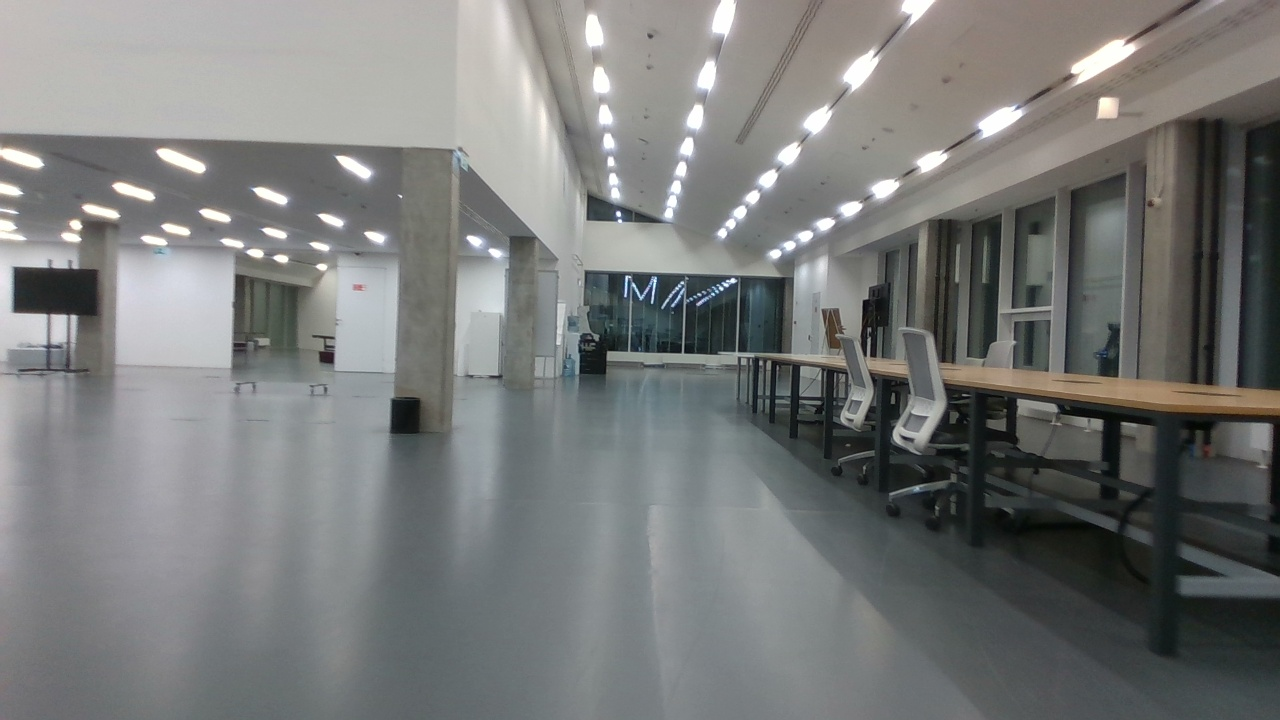

In [9]:
image = PIL.Image.open(df['image_path'].loc[26])
image.show()

# Scene graph for 1 image

In [86]:
import torch
import numpy as np
import cv2

from pathlib import Path

%matplotlib inline
import matplotlib.pyplot as plt


# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import sys
import numpy as np
import os, json, random

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

# Detic libraries
sys.path.insert(0, '/home/altair/gan/final/Detic/third_party/CenterNet2/')
sys.path.append("/home/altair/gan/final/Detic")
from centernet.config import add_centernet_config
import detic
from detic.config import add_detic_config
from detic.modeling.utils import reset_cls_test

In [87]:
import inspect
Path(inspect.getfile(detic)).parent.parent

PosixPath('/home/altair/gan/final/Detic')

In [88]:
# Build the detector and download our pretrained weights
cfg = get_cfg()
add_centernet_config(cfg)
add_detic_config(cfg)
cfg.merge_from_file("/home/altair/gan/final/Detic/configs/Detic_LCOCOI21k_CLIP_SwinB_896b32_4x_ft4x_max-size.yaml")
cfg.MODEL.WEIGHTS = 'https://dl.fbaipublicfiles.com/detic/Detic_LCOCOI21k_CLIP_SwinB_896b32_4x_ft4x_max-size.pth'
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
cfg.MODEL.ROI_BOX_HEAD.ZEROSHOT_WEIGHT_PATH = 'rand'
cfg.MODEL.ROI_HEADS.ONE_CLASS_PER_PROPOSAL = True # For better visualization purpose. Set to False for all classes.
# cfg.MODEL.DEVICE='cpu' # uncomment this to use cpu-only mode.
predictor = DefaultPredictor(cfg)

[10/24 00:24:31 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detic/Detic_LCOCOI21k_CLIP_SwinB_896b32_4x_ft4x_max-size.pth ...


In [89]:
# Setup the model's vocabulary using build-in datasets

BUILDIN_CLASSIFIER = {
    'lvis': '/home/altair/gan/final/Detic/datasets/metadata/lvis_v1_clip_a+cname.npy',
    'objects365': '/home/altair/gan/final/Detic/datasets/metadata/o365_clip_a+cnamefix.npy',
    'openimages': '/home/altair/gan/final/Detic/datasets/metadata/oid_clip_a+cname.npy',
    'coco': '/home/altair/gan/final/Detic/datasets/metadata/coco_clip_a+cname.npy',
}

BUILDIN_METADATA_PATH = {
    'lvis': 'lvis_v1_val',
    'objects365': 'objects365_v2_val',
    'openimages': 'oid_val_expanded',
    'coco': 'coco_2017_val',
}

vocabulary = 'lvis' # change to 'lvis', 'objects365', 'openimages', or 'coco'
metadata = MetadataCatalog.get(BUILDIN_METADATA_PATH[vocabulary])
classifier = BUILDIN_CLASSIFIER[vocabulary]
num_classes = len(metadata.thing_classes)
reset_cls_test(predictor.model, classifier, num_classes)

Resetting zs_weight /home/altair/gan/final/Detic/datasets/metadata/lvis_v1_clip_a+cname.npy


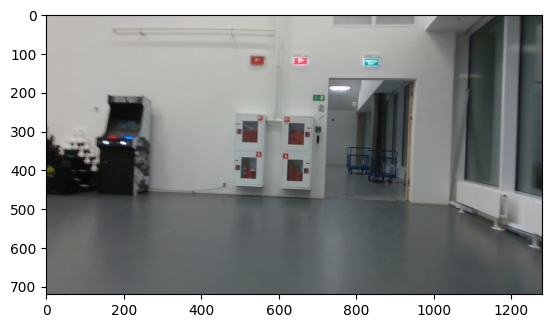

In [90]:
im = cv2.cvtColor(cv2.imread(df['image_path'].loc[15]), cv2.COLOR_BGR2RGB)
plt.imshow(im)

In [91]:
outputs = predictor(im)
v = Visualizer(im[:, :, ::-1], metadata)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.figure(figsize=(16, 16))
plt.imshow((out.get_image()[:, :, ::-1]))

In [92]:
objetcs_dict = {}
counters = {}
for i in range(len(outputs["instances"])):
    box = outputs["instances"].pred_boxes[i].tensor.clone().detach().cpu().numpy().round().astype(int).tolist()
    class_name = metadata.thing_classes[outputs["instances"].pred_classes[i].item()]
    if class_name in counters:
        idx = counters[class_name] + 1
        counters[class_name] = idx
        object_name = f"{class_name}_{idx}"
    else:
        counters[class_name] = 1
        object_name = f"{class_name}_1"
    objetcs_dict[object_name] = box

In [93]:
objetcs_dict

{'vent_1': [[735, 0, 960, 33]],
 'cart_1': [[825, 350, 909, 435]],
 'crossbar_1': [[778, 360, 835, 365]],
 'mop_1': [[1041, 192, 1095, 493]],
 'reflector_1': [[202, 313, 228, 324]],
 'headlight_1': [[191, 327, 207, 337]],
 'fire_extinguisher_1': [[698, 313, 705, 332]],
 'lightbulb_1': [[732, 186, 785, 195]],
 'pipe_1': [[587, 4, 604, 275]],
 'mirror_1': [[1082, 1, 1181, 444]],
 'brass_plaque_1': [[820, 113, 861, 135]]}

# Scene graph for all images

In [11]:
import pandas as pd
import numpy as np
import torch
import cv2
import os
from pathlib import Path
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

# Импортируем необходимые модули для Detectron2 и Detic
import sys
sys.path.insert(0, '/home/altair/gan/final/Detic/third_party/CenterNet2/')
sys.path.append("/home/altair/gan/final/Detic")
from detectron2.utils.logger import setup_logger
setup_logger()

from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor
from detectron2.data import MetadataCatalog
from centernet.config import add_centernet_config
import detic
from detic.config import add_detic_config
from detic.modeling.utils import reset_cls_test

In [12]:
# Функция для настройки и инициализации предиктора
def setup_predictor():
    cfg = get_cfg()
    add_centernet_config(cfg)
    add_detic_config(cfg)
    cfg.merge_from_file("/home/altair/gan/final/Detic/configs/Detic_LCOCOI21k_CLIP_SwinB_896b32_4x_ft4x_max-size.yaml")
    cfg.MODEL.WEIGHTS = 'https://dl.fbaipublicfiles.com/detic/Detic_LCOCOI21k_CLIP_SwinB_896b32_4x_ft4x_max-size.pth'
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # порог уверенности
    cfg.MODEL.ROI_BOX_HEAD.ZEROSHOT_WEIGHT_PATH = 'rand'
    cfg.MODEL.ROI_HEADS.ONE_CLASS_PER_PROPOSAL = True  # Для визуализации. Установите False для всех классов.
    # cfg.MODEL.DEVICE='cpu'  # Раскомментируйте, если хотите использовать CPU
    predictor = DefaultPredictor(cfg)

    # Настраиваем словарь модели
    BUILDIN_CLASSIFIER = {
        'lvis': '/home/altair/gan/final/Detic/datasets/metadata/lvis_v1_clip_a+cname.npy',
        'objects365': '/home/altair/gan/final/Detic/datasets/metadata/o365_clip_a+cnamefix.npy',
        'openimages': '/home/altair/gan/final/Detic/datasets/metadata/oid_clip_a+cname.npy',
        'coco': '/home/altair/gan/final/Detic/datasets/metadata/coco_clip_a+cname.npy',
    }

    BUILDIN_METADATA_PATH = {
        'lvis': 'lvis_v1_val',
        'objects365': 'objects365_v2_val',
        'openimages': 'oid_val_expanded',
        'coco': 'coco_2017_val',
    }

    vocabulary = 'lvis'  # Можно изменить на 'objects365', 'openimages' или 'coco'
    metadata = MetadataCatalog.get(BUILDIN_METADATA_PATH[vocabulary])
    classifier = BUILDIN_CLASSIFIER[vocabulary]
    num_classes = len(metadata.thing_classes)
    reset_cls_test(predictor.model, classifier, num_classes)

    return predictor, metadata

In [13]:
# Функция для обработки одного изображения и получения графа сцены
def get_scene_graph(image_path, predictor, metadata):
    im = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
    outputs = predictor(im)

    objects_dict = {}
    counters = {}
    for i in range(len(outputs["instances"])):
        box = outputs["instances"].pred_boxes[i].tensor.clone().detach().cpu().numpy().round().astype(int).tolist()
        class_name = metadata.thing_classes[outputs["instances"].pred_classes[i].item()]
        if class_name in counters:
            idx = counters[class_name] + 1
            counters[class_name] = idx
            object_name = f"{class_name}_{idx}"
        else:
            counters[class_name] = 1
            object_name = f"{class_name}_1"
        objects_dict[object_name] = box

    return objects_dict

In [14]:
# Функция для разбиения списка на батчи
def batchify(lst, batch_size):
    """Разбивает список lst на батчи размера batch_size."""
    for i in range(0, len(lst), batch_size):
        yield lst[i:i + batch_size]

In [15]:
# Основная функция для обработки DataFrame
def process_images(df, batch_size=5):
    # Инициализируем предиктор и метаданные
    predictor, metadata = setup_predictor()

    # Проверяем, есть ли колонка 'scene_graph' в DataFrame
    if 'scene_graph' not in df.columns:
        df['scene_graph'] = None

    # Определяем индексы, которые нужно обработать
    indices_to_process = df[df['scene_graph'].isnull()].index.tolist()

    # Путь для сохранения CSV-файла
    save_path = '/home/altair/gan/final/multinav/notebooks'
    os.makedirs(save_path, exist_ok=True)  # Создает директорию, если она не существует
    csv_file = os.path.join(save_path, 'llava_outputs.csv')

    # Обрабатываем изображения батчами с прогресс-баром
    for batch_indices in tqdm(batchify(indices_to_process, batch_size), total=(len(indices_to_process) + batch_size - 1) // batch_size, desc="Processing images"):
        # Обрабатываем каждое изображение в батче
        for idx in batch_indices:
            image_path = df.loc[idx, 'image_path']
            try:
                scene_graph = get_scene_graph(image_path, predictor, metadata)
                df.at[idx, 'scene_graph'] = scene_graph
            except Exception as e:
                print(f"Error processing image at index {idx}: {e}")
                df.at[idx, 'scene_graph'] = None
                continue

        # Сохраняем промежуточные результаты каждые 10 строк
        if idx % 10 == 0:
            df.to_csv(csv_file, index=False)
            print(f"Saved up to index {idx} to {csv_file}")

        # Освобождаем память GPU
        torch.cuda.empty_cache()

    # Сохраняем окончательные результаты
    df.to_csv(csv_file, index=False)
    print(f"Processing completed. Results saved to {csv_file}")

In [16]:
# Загрузка DataFrame
df = pd.read_csv('/home/altair/gan/final/multinav/notebooks/llava_outputs.csv')

In [17]:
df

image_path  \
0   /mnt/vol0/datasets/rosbag2_navigation_for_grap...   
1   /mnt/vol0/datasets/rosbag2_navigation_for_grap...   
2   /mnt/vol0/datasets/rosbag2_navigation_for_grap...   
3   /mnt/vol0/datasets/rosbag2_navigation_for_grap...   
4   /mnt/vol0/datasets/rosbag2_navigation_for_grap...   
..                                                ...   
60  /mnt/vol0/datasets/rosbag2_navigation_for_grap...   
61  /mnt/vol0/datasets/rosbag2_navigation_for_grap...   
62  /mnt/vol0/datasets/rosbag2_navigation_for_grap...   
63  /mnt/vol0/datasets/rosbag2_navigation_for_grap...   
64  /mnt/vol0/datasets/rosbag2_navigation_for_grap...   

                                               output  \
0   In the image, I see a whiteboard mounted on a ...   
1   The image shows an interior space that appears...   
2   The image shows an interior space that appears...   
3   The image shows a view through an open doorway...   
4   The image shows an interior hallway of a build...   
..                                                ...   
60  The image depicts an interior space that appea...   
61  The image shows an interior view of a modern o...   
62  The image shows an interior view of a modern o...   
63  The image shows an interior hallway with a mod...   
64  The image shows an interior space that appears...   

                                          scene_graph  
0   {'trash_can_1': [[728, 531, 816, 658]], 'wall_...  
1   {'chair_1': [[536, 341, 581, 428]], 'trash_can...  
2   {'bottle_1': [[1113, 497, 1233, 694]], 'refrig...  
3   {'handle_1': [[0, 74, 126, 133]], 'refrigerato...  
4   {'sofa_1': [[173, 417, 385, 674]], 'lightbulb_...  
..                                                ...  
60  {'television_set_1': [[800, 279, 952, 348]], '...  
61  {'chair_1': [[931, 333, 1188, 694]], 'train_(r...  
62  {'chair_1': [[136, 311, 279, 501]], 'drawer_1'...  
63  {'lightbulb_1': [[630, 0, 653, 72]], 'hinge_1'...  
64  {'chair_1': [[312, 358, 419, 469]], 'drawer_1'...  

[65 rows x 3 columns]

In [18]:
# Запуск обработки
process_images(df, batch_size=4)

/home/altair/miniconda3/envs/lenv/lib/python3.12/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[10/23 23:42:48 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detic/Detic_LCOCOI21k_CLIP_SwinB_896b32_4x_ft4x_max-size.pth ...
Resetting zs_weight /home/altair/gan/final/Detic/datasets/metadata/lvis_v1_clip_a+cname.npy


Processing images: 0it [00:00, ?it/s]

Processing completed. Results saved to /home/altair/gan/final/multinav/notebooks/llava_outputs.csv


In [19]:
# Загрузка DataFrame
df = pd.read_csv('/home/altair/gan/final/multinav/notebooks/llava_outputs.csv')

In [20]:
df

image_path  \
0   /mnt/vol0/datasets/rosbag2_navigation_for_grap...   
1   /mnt/vol0/datasets/rosbag2_navigation_for_grap...   
2   /mnt/vol0/datasets/rosbag2_navigation_for_grap...   
3   /mnt/vol0/datasets/rosbag2_navigation_for_grap...   
4   /mnt/vol0/datasets/rosbag2_navigation_for_grap...   
..                                                ...   
60  /mnt/vol0/datasets/rosbag2_navigation_for_grap...   
61  /mnt/vol0/datasets/rosbag2_navigation_for_grap...   
62  /mnt/vol0/datasets/rosbag2_navigation_for_grap...   
63  /mnt/vol0/datasets/rosbag2_navigation_for_grap...   
64  /mnt/vol0/datasets/rosbag2_navigation_for_grap...   

                                               output  \
0   In the image, I see a whiteboard mounted on a ...   
1   The image shows an interior space that appears...   
2   The image shows an interior space that appears...   
3   The image shows a view through an open doorway...   
4   The image shows an interior hallway of a build...   
..                                                ...   
60  The image depicts an interior space that appea...   
61  The image shows an interior view of a modern o...   
62  The image shows an interior view of a modern o...   
63  The image shows an interior hallway with a mod...   
64  The image shows an interior space that appears...   

                                          scene_graph  
0   {'trash_can_1': [[728, 531, 816, 658]], 'wall_...  
1   {'chair_1': [[536, 341, 581, 428]], 'trash_can...  
2   {'bottle_1': [[1113, 497, 1233, 694]], 'refrig...  
3   {'handle_1': [[0, 74, 126, 133]], 'refrigerato...  
4   {'sofa_1': [[173, 417, 385, 674]], 'lightbulb_...  
..                                                ...  
60  {'television_set_1': [[800, 279, 952, 348]], '...  
61  {'chair_1': [[931, 333, 1188, 694]], 'train_(r...  
62  {'chair_1': [[136, 311, 279, 501]], 'drawer_1'...  
63  {'lightbulb_1': [[630, 0, 653, 72]], 'hinge_1'...  
64  {'chair_1': [[312, 358, 419, 469]], 'drawer_1'...  

[65 rows x 3 columns]

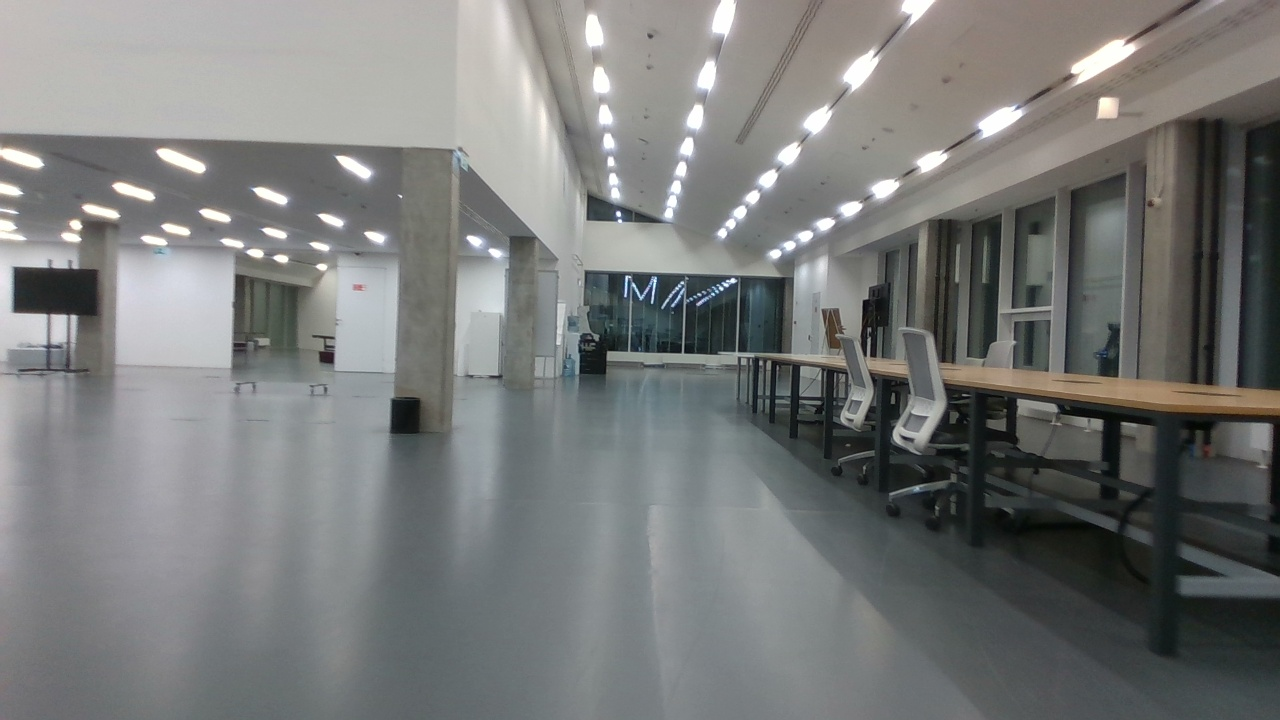

In [64]:
image = PIL.Image.open(df['image_path'].loc[26])
image.show()

In [22]:
df['scene_graph'].loc[26]

"{'television_set_1': [[13, 267, 99, 316]], 'chair_1': [[886, 327, 970, 529]], 'lightbulb_1': [[804, 107, 831, 133]], 'chair_2': [[837, 335, 875, 432]], 'lightbulb_2': [[698, 61, 716, 89]], 'lightbulb_3': [[687, 104, 704, 130]], 'lampshade_1': [[1025, 235, 1053, 287]], 'trash_can_1': [[390, 397, 421, 434]], 'lightbulb_4': [[733, 206, 747, 219]], 'lightbulb_5': [[593, 67, 610, 93]], 'lightbulb_6': [[712, 0, 736, 33]], 'lightbulb_7': [[680, 137, 694, 157]], 'lightbulb_8': [[759, 169, 778, 188]], 'lightbulb_9': [[843, 56, 876, 90]], 'lightbulb_10': [[777, 143, 800, 165]], 'lightbulb_11': [[840, 202, 862, 217]], 'lightbulb_12': [[602, 134, 615, 149]], 'box_1': [[5, 344, 65, 370]], 'chair_3': [[982, 340, 1018, 447]], 'lightbulb_13': [[598, 105, 613, 125]], 'lightbulb_14': [[717, 229, 727, 238]], 'lightbulb_15': [[585, 14, 604, 47]], 'lightbulb_16': [[667, 195, 677, 207]], 'lightbulb_17': [[901, 0, 934, 16]], 'lightbulb_18': [[675, 162, 687, 178]], 'lightbulb_19': [[489, 249, 501, 259]], 'ch

In [23]:
prefix = "You are given with a JSON-like description of the scene. This description is a dictionary where the key is the class name and ID of the object, and value is the bounding box of the object in the source image. Based on this dictionary, you are asked to generate a graph-like description of the scene. You need to summarize spatial relationships between the objects on the scene. Be brief and precise, don't give introductory and conclusion words. Focus on the meaningful part of the response. Also ignore following classes: person, lightbulb. \n"

df['gpt_prompt'] = df['scene_graph'].apply(lambda x: prefix + x)


In [24]:
print(df['gpt_prompt'].loc[26])

You are given with a JSON-like description of the scene. This description is a dictionary where the key is the class name and ID of the object, and value is the bounding box of the object in the source image. Based on this dictionary, you are asked to generate a graph-like description of the scene. You need to summarize spatial relationships between the objects on the scene. Be brief and precise, don't give introductory and conclusion words. Focus on the meaningful part of the response. Also ignore following classes: person, lightbulb. 
{'television_set_1': [[13, 267, 99, 316]], 'chair_1': [[886, 327, 970, 529]], 'lightbulb_1': [[804, 107, 831, 133]], 'chair_2': [[837, 335, 875, 432]], 'lightbulb_2': [[698, 61, 716, 89]], 'lightbulb_3': [[687, 104, 704, 130]], 'lampshade_1': [[1025, 235, 1053, 287]], 'trash_can_1': [[390, 397, 421, 434]], 'lightbulb_4': [[733, 206, 747, 219]], 'lightbulb_5': [[593, 67, 610, 93]], 'lightbulb_6': [[712, 0, 736, 33]], 'lightbulb_7': [[680, 137, 694, 157]]

In [25]:
df

image_path  \
0   /mnt/vol0/datasets/rosbag2_navigation_for_grap...   
1   /mnt/vol0/datasets/rosbag2_navigation_for_grap...   
2   /mnt/vol0/datasets/rosbag2_navigation_for_grap...   
3   /mnt/vol0/datasets/rosbag2_navigation_for_grap...   
4   /mnt/vol0/datasets/rosbag2_navigation_for_grap...   
..                                                ...   
60  /mnt/vol0/datasets/rosbag2_navigation_for_grap...   
61  /mnt/vol0/datasets/rosbag2_navigation_for_grap...   
62  /mnt/vol0/datasets/rosbag2_navigation_for_grap...   
63  /mnt/vol0/datasets/rosbag2_navigation_for_grap...   
64  /mnt/vol0/datasets/rosbag2_navigation_for_grap...   

                                               output  \
0   In the image, I see a whiteboard mounted on a ...   
1   The image shows an interior space that appears...   
2   The image shows an interior space that appears...   
3   The image shows a view through an open doorway...   
4   The image shows an interior hallway of a build...   
..                                                ...   
60  The image depicts an interior space that appea...   
61  The image shows an interior view of a modern o...   
62  The image shows an interior view of a modern o...   
63  The image shows an interior hallway with a mod...   
64  The image shows an interior space that appears...   

                                          scene_graph  \
0   {'trash_can_1': [[728, 531, 816, 658]], 'wall_...   
1   {'chair_1': [[536, 341, 581, 428]], 'trash_can...   
2   {'bottle_1': [[1113, 497, 1233, 694]], 'refrig...   
3   {'handle_1': [[0, 74, 126, 133]], 'refrigerato...   
4   {'sofa_1': [[173, 417, 385, 674]], 'lightbulb_...   
..                                                ...   
60  {'television_set_1': [[800, 279, 952, 348]], '...   
61  {'chair_1': [[931, 333, 1188, 694]], 'train_(r...   
62  {'chair_1': [[136, 311, 279, 501]], 'drawer_1'...   
63  {'lightbulb_1': [[630, 0, 653, 72]], 'hinge_1'...   
64  {'chair_1': [[312, 358, 419, 469]], 'drawer_1'...   

                                           gpt_prompt  
0   You are given with a JSON-like description of ...  
1   You are given with a JSON-like description of ...  
2   You are given with a JSON-like description of ...  
3   You are given with a JSON-like description of ...  
4   You are given with a JSON-like description of ...  
..                                                ...  
60  You are given with a JSON-like description of ...  
61  You are given with a JSON-like description of ...  
62  You are given with a JSON-like description of ...  
63  You are given with a JSON-like description of ...  
64  You are given with a JSON-like description of ...  

[65 rows x 4 columns]

In [26]:
df.to_csv('/home/altair/gan/final/multinav/notebooks/llava_outputs.csv', index=False)

# Batch file creation for ChatGPT requests

In [64]:
!pip install openai httpx[socks] httpcore[socks]

In [70]:
!pip install socksio

In [27]:
import pandas as pd
import json
from openai import OpenAI
import os
import httpx

In [28]:
client = OpenAI(api_key="OpenAI_API_key",
                http_client=httpx.Client(proxies={
    "http",
    "https"
}))

In [29]:
import pandas as pd
import json

# Загрузка DataFrame
df = pd.read_csv('/home/altair/gan/final/multinav/notebooks/llava_outputs.csv')

In [30]:
df

image_path  \
0   /mnt/vol0/datasets/rosbag2_navigation_for_grap...   
1   /mnt/vol0/datasets/rosbag2_navigation_for_grap...   
2   /mnt/vol0/datasets/rosbag2_navigation_for_grap...   
3   /mnt/vol0/datasets/rosbag2_navigation_for_grap...   
4   /mnt/vol0/datasets/rosbag2_navigation_for_grap...   
..                                                ...   
60  /mnt/vol0/datasets/rosbag2_navigation_for_grap...   
61  /mnt/vol0/datasets/rosbag2_navigation_for_grap...   
62  /mnt/vol0/datasets/rosbag2_navigation_for_grap...   
63  /mnt/vol0/datasets/rosbag2_navigation_for_grap...   
64  /mnt/vol0/datasets/rosbag2_navigation_for_grap...   

                                               output  \
0   In the image, I see a whiteboard mounted on a ...   
1   The image shows an interior space that appears...   
2   The image shows an interior space that appears...   
3   The image shows a view through an open doorway...   
4   The image shows an interior hallway of a build...   
..                                                ...   
60  The image depicts an interior space that appea...   
61  The image shows an interior view of a modern o...   
62  The image shows an interior view of a modern o...   
63  The image shows an interior hallway with a mod...   
64  The image shows an interior space that appears...   

                                          scene_graph  \
0   {'trash_can_1': [[728, 531, 816, 658]], 'wall_...   
1   {'chair_1': [[536, 341, 581, 428]], 'trash_can...   
2   {'bottle_1': [[1113, 497, 1233, 694]], 'refrig...   
3   {'handle_1': [[0, 74, 126, 133]], 'refrigerato...   
4   {'sofa_1': [[173, 417, 385, 674]], 'lightbulb_...   
..                                                ...   
60  {'television_set_1': [[800, 279, 952, 348]], '...   
61  {'chair_1': [[931, 333, 1188, 694]], 'train_(r...   
62  {'chair_1': [[136, 311, 279, 501]], 'drawer_1'...   
63  {'lightbulb_1': [[630, 0, 653, 72]], 'hinge_1'...   
64  {'chair_1': [[312, 358, 419, 469]], 'drawer_1'...   

                                           gpt_prompt  
0   You are given with a JSON-like description of ...  
1   You are given with a JSON-like description of ...  
2   You are given with a JSON-like description of ...  
3   You are given with a JSON-like description of ...  
4   You are given with a JSON-like description of ...  
..                                                ...  
60  You are given with a JSON-like description of ...  
61  You are given with a JSON-like description of ...  
62  You are given with a JSON-like description of ...  
63  You are given with a JSON-like description of ...  
64  You are given with a JSON-like description of ...  

[65 rows x 4 columns]

In [34]:
# Проверка наличия колонки 'gpt_promt'
if 'gpt_prompt' not in df.columns:
    raise ValueError("DataFrame должен содержать колонку 'gpt_prompt'.")

In [35]:
# Параметры для Batch API
system_prompt = "You are expert for embodied robot navigation."
model_name = "gpt-4o"
output_file = '/home/altair/gan/final/multinav/notebooks/batch_input.jsonl'

In [37]:
# Функция для создания запроса Batch API
def create_batch_request(custom_id, system_prompt, user_prompt, model_name):
    request = {
        "custom_id": custom_id,
        "method": "POST",
        "url": "/v1/chat/completions",
        "body": {
            "model": model_name,
            "max_tokens": 1000,
            "temperature": 0,
            "messages": [
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": user_prompt}
            ],
        }
    }
    return request

In [114]:
# Создание JSONL-файла
with open(output_file, 'w', encoding='utf-8') as f:
    for index, row in df.iterrows():
        custom_id = f"request-{index}"
        user_prompt = row['gpt_prompt']
        request = create_batch_request(custom_id, system_prompt, user_prompt, model_name)
        json_line = json.dumps(request, ensure_ascii=False)
        f.write(json_line + '\n')

print(f"JSONL-файл успешно создан: {output_file}")

JSONL-файл успешно создан: /home/altair/gan/final/multinav/notebooks/batch_input.jsonl


In [115]:
# Загрузка файла на сервер OpenAI через клиент
# Загрузка файла
with open(output_file, 'rb') as f:
    batch_input_file = client.files.create(
        file=f,
        purpose='batch'
    )

print(f"Файл загружен. ID файла: {batch_input_file.id}")

Файл загружен. ID файла: file-HwvCARZIru0pAcEYY67hkumR


In [116]:
batch_input_file

FileObject(id='file-HwvCARZIru0pAcEYY67hkumR', bytes=110659, created_at=1729730148, filename='batch_input.jsonl', object='file', purpose='batch', status='processed', status_details=None)

In [117]:
# Создание Batch Job через клиент
# Получаем ID загруженного файла
batch_input_file_id = batch_input_file.id

# Создаем батч
batch = client.batches.create(
    input_file_id=batch_input_file_id,
    endpoint="/v1/chat/completions",
    completion_window="24h",
    metadata={
        "description": "Batch job for processing prompts"
    }
)

print(f"Батч создан. ID батча: {batch.id}")


Батч создан. ID батча: batch_67199666ca288190881e6b2c6fd6f9c6


In [118]:
# Проверка статуса батча через клиент
import time

batch_id = batch.id

# Проверяем статус батча каждые 60 секунд
while True:
    batch_status = client.batches.retrieve(batch_id)
    status = batch_status.status
    print(f"Текущий статус батча: {status}")
    if status == 'completed':
        print("Батч завершен.")
        break
    elif status in ['failed', 'cancelled']:
        print(f"Батч завершился с ошибкой. Статус: {status}")
        break
    else:
        # Ждем 60 секунд перед следующей проверкой
        time.sleep(60)


Текущий статус батча: in_progress
Текущий статус батча: in_progress
Текущий статус батча: in_progress
Текущий статус батча: in_progress
Текущий статус батча: in_progress
Текущий статус батча: in_progress
Текущий статус батча: in_progress
Текущий статус батча: completed
Батч завершен.


In [119]:
# Получение результатов через клиент
if batch_status.status == 'completed':
    # Получаем ID выходного файла
    output_file_id = batch_status.output_file_id

    # Загружаем содержимое файла
    output_content_response = client.files.content(output_file_id)
    output_content = output_content_response.text

    # Сохраняем результаты в файл
    results_file = '/home/altair/gan/final/multinav/notebooks/batch_output.jsonl'
    with open(results_file, 'w', encoding='utf-8') as f:
        f.write(output_content)

    print(f"Результаты сохранены в {results_file}")
else:
    print(f"Не удалось получить результаты. Статус батча: {batch_status.status}")


Результаты сохранены в /home/altair/gan/final/multinav/notebooks/batch_output.jsonl


In [120]:
# Обработка результатов и обновление DataFrame
# Загрузка результатов из файла
results = []
with open(results_file, 'r', encoding='utf-8') as f:
    for line in f:
        result = json.loads(line)
        results.append(result)

# Создаем словарь для быстрого доступа по custom_id
results_dict = {res['custom_id']: res for res in results}

# Добавляем ответы в DataFrame
responses = []
for index, row in df.iterrows():
    custom_id = f"request-{index}"
    result = results_dict.get(custom_id)
    if result and 'response' in result and 'body' in result['response']:
        answer = result['response']['body']['choices'][0]['message']['content']
    else:
        answer = None
    responses.append(answer)

# Добавляем новую колонку в DataFrame
df['gpt_response'] = responses

# Сохраняем обновленный DataFrame
df.to_csv('/home/altair/gan/final/multinav/notebooks/llava_outputs_with_responses.csv', index=False)

print("DataFrame обновлен и сохранен.")


DataFrame обновлен и сохранен.


In [121]:
df = pd.read_csv('/home/altair/gan/final/multinav/notebooks/llava_outputs_with_responses.csv')

In [122]:
df

image_path  \
0   /mnt/vol0/datasets/rosbag2_navigation_for_grap...   
1   /mnt/vol0/datasets/rosbag2_navigation_for_grap...   
2   /mnt/vol0/datasets/rosbag2_navigation_for_grap...   
3   /mnt/vol0/datasets/rosbag2_navigation_for_grap...   
4   /mnt/vol0/datasets/rosbag2_navigation_for_grap...   
..                                                ...   
60  /mnt/vol0/datasets/rosbag2_navigation_for_grap...   
61  /mnt/vol0/datasets/rosbag2_navigation_for_grap...   
62  /mnt/vol0/datasets/rosbag2_navigation_for_grap...   
63  /mnt/vol0/datasets/rosbag2_navigation_for_grap...   
64  /mnt/vol0/datasets/rosbag2_navigation_for_grap...   

                                               output  \
0   In the image, I see a whiteboard mounted on a ...   
1   The image shows an interior space that appears...   
2   The image shows an interior space that appears...   
3   The image shows a view through an open doorway...   
4   The image shows an interior hallway of a build...   
..                                                ...   
60  The image depicts an interior space that appea...   
61  The image shows an interior view of a modern o...   
62  The image shows an interior view of a modern o...   
63  The image shows an interior hallway with a mod...   
64  The image shows an interior space that appears...   

                                          scene_graph  \
0   {'trash_can_1': [[728, 531, 816, 658]], 'wall_...   
1   {'chair_1': [[536, 341, 581, 428]], 'trash_can...   
2   {'bottle_1': [[1113, 497, 1233, 694]], 'refrig...   
3   {'handle_1': [[0, 74, 126, 133]], 'refrigerato...   
4   {'sofa_1': [[173, 417, 385, 674]], 'lightbulb_...   
..                                                ...   
60  {'television_set_1': [[800, 279, 952, 348]], '...   
61  {'chair_1': [[931, 333, 1188, 694]], 'train_(r...   
62  {'chair_1': [[136, 311, 279, 501]], 'drawer_1'...   
63  {'lightbulb_1': [[630, 0, 653, 72]], 'hinge_1'...   
64  {'chair_1': [[312, 358, 419, 469]], 'drawer_1'...   

                                           gpt_prompt  \
0   You are given with a JSON-like description of ...   
1   You are given with a JSON-like description of ...   
2   You are given with a JSON-like description of ...   
3   You are given with a JSON-like description of ...   
4   You are given with a JSON-like description of ...   
..                                                ...   
60  You are given with a JSON-like description of ...   
61  You are given with a JSON-like description of ...   
62  You are given with a JSON-like description of ...   
63  You are given with a JSON-like description of ...   
64  You are given with a JSON-like description of ...   

                                         gpt_response  
0   - Trash can is below the bulletin board and to...  
1   - Chair_1 is to the left of Trash_can_1 and Bu...  
2   - Bottle_1 is to the right of Refrigerator_1 a...  
3        - handle_1 is located on the refrigerator_1.  
4   - Sofa_1 is to the left of Toilet_tissue_1, Ba...  
..                                                ...  
60  - Television_set_1 is above chair_1 and to the...  
61  - train_(railroad_vehicle)_1 is to the left of...  
62  - Chair_1 is to the left of Chair_2.\n- Chair_...  
63  - Hinge_1 is near the bottom center of the sce...  
64  - Chair_1 is to the left of Refrigerator_1.\n-...  

[65 rows x 5 columns]

In [127]:
img = df.loc[25]
im = cv2.cvtColor(cv2.imread(img.image_path), cv2.COLOR_BGR2RGB)
outputs = predictor(im)
v = Visualizer(im[:, :, ::-1], metadata)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.figure(figsize=(16, 16))
plt.imshow((out.get_image()[:, :, ::-1]))
plt.show()

print(img.output)
print('\n')
print(img.scene_graph)
print('\n')
print(img.gpt_prompt)
print('\n')
print(img.gpt_response)

The image shows an interior space that appears to be a large, open area with a high ceiling and a modern design. The floor is a light gray color, and there are no visible people in the space.

In the foreground, there is a black barrier or partition on the left side, which could be a temporary setup or a part of the room's design. Beyond the barrier, there is a row of tables and chairs, suggesting a dining or meeting area. The tables and chairs are arranged in a straight line, and there are no people seated at them.

The middle ground of the image shows a series of columns that support the ceiling, which is fitted with recessed lighting. The lighting creates a bright and even illumination throughout the space.

In the background, there is a large window that allows natural light to enter the room. The window is framed by a white structure that could be part of the building's architecture.

The overall impression is of a spacious, well-lit room that is currently unoccupied, possibly awa